In [1]:
import xarray as xr
import pandas as pd
import numpy as np

from datetime import datetime
import shutil, os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
input_data_directory = '/home/sreenath/Documents/Work/NOAA/SPLASH/Tower_Data/netcdf_trials'

#right now I'm just reading in two example files

file_name_list = []
for file in os.listdir(input_data_directory):
    file_name_list.append(file)


In [3]:
file_name_list

['KP22_001-365.MET30X', 'KPA22_001.FLX1']

In [4]:
met_df = pd.read_table( (input_data_directory + '/' + file_name_list[0]),delimiter=r"\s+")#,skiprows = [1]
met_df.head()

,date,time(MST),DecDay,wsp_3m,wsp_5m,wsp_10m,dir_3m,dir_5m,dir_10m,stheta_3m,...,SoilT2b_Avg,SoilT5b_Avg,SoilT10b_Avg,SoilT20b_Avg,SoilT50b_Avg,SoilT2c_Avg,SoilT5c_Avg,SoilT10c_Avg,SoilT20c_Avg,SoilT50c_Avg
0,2022-01-01,00:30:00,1.021,1.711,1.862,2.037,312.8,313.2,306.1,7.2,...,-0.27,-0.19,-0.03,0.52,1.96,-0.3,-0.23,-0.16,0.13,1.91
1,2022-01-01,01:00:00,1.042,1.896,2.078,2.300,288.7,290.5,287.5,4.8,...,-0.27,-0.19,-0.03,0.52,1.96,-0.3,-0.23,-0.16,0.13,1.91
2,2022-01-01,01:30:00,1.062,1.082,1.232,1.506,283.5,296.2,292.1,9.2,...,-0.27,-0.19,-0.03,0.52,1.96,-0.3,-0.23,-0.16,0.13,1.91
3,2022-01-01,02:00:00,1.083,2.079,2.244,2.487,305.8,307.7,304.0,3.7,...,-0.27,-0.19,-0.03,0.52,1.96,-0.3,-0.23,-0.16,0.13,1.91
4,2022-01-01,02:30:00,1.104,2.120,2.293,2.581,315.1,311.0,301.5,5.1,...,-0.26,-0.19,-0.03,0.52,1.96,-0.3,-0.23,-0.16,0.13,1.91


In [5]:
print(met_df.columns.to_list())

['date', 'time(MST)', 'DecDay', 'wsp_3m', 'wsp_5m', 'wsp_10m', 'dir_3m', 'dir_5m', 'dir_10m', 'stheta_3m', 'stheta_5m', 'stheta_10m', 'Pressure_Avg', 'RH_Avg', 'Tair1_3m', 'Tair2_3m', 'Tair1_5m', 'Tair2_5m', 'Tair1_10m', 'Tair2_10m', 'SurfT1_C', 'SurfT2_C', 'SurfT3_C', 'SurfTave_C', 'del_Ts', 'del_ws', 'emm', 'T3m_T5m', 'Ts_Ta', 'NetBodyT', 'Rg_in_avg', 'Rg_out_avg', 'Lw_in_avg', 'Lw_out_avg', 'ghflx_a', 'ghflx_b', 'ghflx_c', 'stor_a', 'stor_b', 'stor_c', 'SoilT2a_Avg', 'SoilT5a_Avg', 'SoilT10a_Avg', 'SoilT20a_Avg', 'SoilT50a_Avg', 'SoilT2b_Avg', 'SoilT5b_Avg', 'SoilT10b_Avg', 'SoilT20b_Avg', 'SoilT50b_Avg', 'SoilT2c_Avg', 'SoilT5c_Avg', 'SoilT10c_Avg', 'SoilT20c_Avg', 'SoilT50c_Avg']


In [6]:

met_df['date_time'] = pd.to_datetime(met_df['date'] + ' ' + met_df['time(MST)'])


In [60]:
#creating coordinates and dimensions for the dataset
date_time = np.asarray(met_df['date_time'])
z = np.asarray([3,5,10]) #vertical height array
zsoil = np.asarray([2,5,10,20,50]) #soil height array, increasing values mean deeper layer
soil_loc = np.asarray(['a', 'b', 'c'])
now = datetime.now()


In [61]:
nc_output = xr.Dataset()

#insert dataset metadata as attributes
nc_output.attrs['description'] = f'Contains meteorological data from NOAA ARL Kettle Ponds site [site_id]'
nc_output.attrs['authors'] = 'Sreenath Paleri (sreenath.paleri@noaa.gov), Tilden Meyers (tilden.meyers@noaa.gov), Mark Heuer (mark.heuer@noaa.gov)' 
nc_output.attrs['history'] = 'Created at ' + now.strftime('%Y-%m-%d %H:%M:%S')
nc_output.attrs['start_time'] =  str(np.array(date_time[0], dtype='datetime64[s]')) + ' MST' #round time to the nearest second and enter
nc_output.attrs['end_time'] =  str(np.array(date_time[-1], dtype='datetime64[s]')) + ' MST' #round time to the nearest second and enter

#insert measurements location/dimensions
nc_output['z'] = xr.DataArray(z, dims=['z'], attrs={'units':'m'})
nc_output['zsoil'] = xr.DataArray(zsoil, dims=['zsoil'], attrs={'units':'m','description': 'depth of soil layer'})
nc_output['time'] = xr.DataArray(date_time, dims=['time'], attrs={'units':'date time'})
nc_output['soil_loc'] = xr.DataArray(soil_loc, dims=['soil_loc'], attrs={'description':'location indicator for soil sensors'})


In [70]:

#convert windspeed at 3 heights into an array of arrays
#convert this into an array with time in rows and heights in columns:
wind_speed = ([met_df['wsp_3m'].values,met_df['wsp_5m'].values,met_df['wsp_10m'].values])
wind_dir = ([met_df['dir_3m'].values,met_df['dir_5m'].values,met_df['dir_10m'].values])
wind_dir_std = ([met_df['stheta_3m'].values,met_df['stheta_5m'].values,met_df['stheta_10m'].values])
Tair1 = ([met_df['Tair1_3m'].values,met_df['Tair1_5m'].values,met_df['Tair1_10m'].values])
Tair2 = ([met_df['Tair2_3m'].values,met_df['Tair2_5m'].values,met_df['Tair2_10m'].values])

surfT1 = (met_df['SurfT1_C'].values)
surfT2 = (met_df['SurfT2_C'].values)
surfT3 = (met_df['SurfT3_C'].values)
#not adding in 'SurfTave_C', 'del_Ts', 'del_ws', 'emm', 'T3m_T5m', 'Ts_Ta', 'NetBodyT' for now
#i don't know what 'del_Ts', 'del_ws', 'emm', and 'NetBodyT' are. The others can be calculated
incoming_short_wave = (met_df['Rg_in_avg'].values)
outgoing_short_wave = (met_df['Rg_out_avg'].values)
incoming_long_wave = (met_df['Lw_in_avg'].values)
outgoing_long_wave = (met_df['Lw_out_avg'].values)
pressure = (met_df['Pressure_Avg'].values)
relative_humidity = (met_df['RH_Avg'].values)

ground_heat_flux = ([met_df['ghflx_a'].values,met_df['ghflx_b'].values,met_df['ghflx_c'].values])
soil_heat_storage = ([met_df['stor_a'].values,met_df['stor_b'].values,met_df['stor_c'].values])

soilT = np.array(
        [
            [met_df['SoilT2a_Avg'].values,met_df['SoilT5a_Avg'].values,met_df['SoilT10a_Avg'].values,met_df['SoilT20a_Avg'].values,met_df['SoilT50a_Avg'].values],
            [met_df['SoilT2b_Avg'].values,met_df['SoilT5b_Avg'].values,met_df['SoilT10b_Avg'].values,met_df['SoilT20b_Avg'].values,met_df['SoilT50b_Avg'].values],
            [met_df['SoilT2c_Avg'].values,met_df['SoilT5c_Avg'].values,met_df['SoilT10c_Avg'].values,met_df['SoilT20c_Avg'].values,met_df['SoilT50c_Avg'].values]
        ]
    )
# np.shape(soilT)
# (3, 5, 17520)
#3 locations, 5 depths and 17520 times


# print(np.shape(wind_speed))
#3, 17520
# #3 rows -> 3 heights,
# #17520 columns -> times
nc_output['wind_speed'] = xr.DataArray(
                            wind_speed,dims=['z','time'],
                            attrs={ 'description' : 'wind speed', 'units':'m/s',
                                    'instrument':'instrument_name', 'accuarcy':'xx m/s','precision':'xx m/s'})
nc_output['wind_dir'] = xr.DataArray(
                            wind_dir,dims=['z','time'],
                            attrs={ 'description' : 'wind direction', 'units':'degrees',
                                    'instrument':'instrument_name', 'accuarcy':'xx degree','precision':'xx degree'})
nc_output['wind_dir_std'] = xr.DataArray(
                            wind_dir_std,dims=['z','time'],
                            attrs={ 'description' : 'standard deviation of wind direction', 'units':'degrees',
                                    'instrument':'instrument_name', 'accuarcy':'xx degree','precision':'xx degree'})
nc_output['Tair1'] = xr.DataArray(
                            Tair1,dims=['z','time'],
                            attrs={ 'description' : 'aspirated air temperature at boom 1', 'units':'celsius',
                                    'instrument':'instrument_name', 'accuarcy':'xx celsius','precision':'xx celsius'})
nc_output['Tair2'] = xr.DataArray(
                            Tair2,dims=['z','time'],
                            attrs={ 'description' : 'aspirated air temperature at boom 2', 'units':'celsius',
                                    'instrument':'instrument_name', 'accuarcy':'xx celsius','precision':'xx celsius'})

nc_output['surfT1'] = xr.DataArray(
                            surfT1,dims=['time'],
                            attrs={ 'description' : 'downward pointing infrared thermometer1 measured surface temp', 'units':'celsius',
                                    'instrument':'instrument_name', 'accuarcy':'xx celsius','precision':'xx celsius'})
nc_output['surfT2'] = xr.DataArray(
                            surfT2,dims=['time'],
                            attrs={ 'description' : 'downward pointing infrared thermometer2 measured surface temp', 'units':'celsius',
                                    'instrument':'instrument_name', 'accuarcy':'xx celsius','precision':'xx celsius'})
nc_output['surfT3'] = xr.DataArray(
                            surfT1,dims=['time'],
                            attrs={ 'description' : 'downward pointing infrared thermometer3 measured surface temp ', 'units':'celsius',
                                    'instrument':'instrument_name', 'accuarcy':'xx celsius','precision':'xx celsius'})

nc_output['incoming_short_wave'] = xr.DataArray(
                            incoming_short_wave,dims=['time'],
                            attrs={ 'description' : 'incoming global (shortwave) radiation', 'units':'W/m2',
                                    'instrument':'instrument_name', 'accuarcy':'xx W/m2','precision':'xx W/m2'})
nc_output['outgoing_short_wave'] = xr.DataArray(
                            outgoing_short_wave,dims=['time'],
                            attrs={ 'description' : 'outgoing global (shortwave) radiation', 'units':'W/m2',
                                    'instrument':'instrument_name', 'accuarcy':'xx W/m2','precision':'xx W/m2'})
nc_output['incoming_long_wave'] = xr.DataArray(
                            incoming_long_wave,dims=['time'],
                            attrs={ 'description' : 'incoming longwave radiation', 'units':'W/m2',
                                    'instrument':'instrument_name', 'accuarcy':'xx W/m2','precision':'xx W/m2'})
nc_output['outgoing_long_wave'] = xr.DataArray(
                            outgoing_long_wave,dims=['time'],
                            attrs={ 'description' : 'outgoing global (shortwave) radiation', 'units':'W/m2',
                                    'instrument':'instrument_name', 'accuarcy':'xx W/m2','precision':'xx W/m2'})

nc_output['pressure'] = xr.DataArray(
                            pressure,dims=['time'],
                            attrs={ 'description' : 'surface pressure', 'units':'mb',
                                    'instrument':'instrument_name', 'accuarcy':'xx mb','precision':'xx mb'})
nc_output['relative_humidity'] = xr.DataArray(
                            relative_humidity,dims=['time'],
                            attrs={ 'description' : 'surface relative humidity', 'units':'%',
                                    'instrument':'instrument_name', 'accuarcy':'xx %','precision':'xx %'})

nc_output['ground_heat_flux'] = xr.DataArray(
                            ground_heat_flux,dims=['soil_loc','time'],
                            attrs={ 'description' : 'heat flux through the soil', 'units':'W/m2',
                                    'instrument':'instrument_name', 'accuarcy':'xx W/m2','precision':'xx W/m2'})
nc_output['soil_heat_storage'] = xr.DataArray(
                            soil_heat_storage,dims=['soil_loc','time'],
                            attrs={ 'description' : 'soil heat storage', 'units':'W/m2',
                                    'instrument':'instrument_name', 'accuarcy':'xx W/m2','precision':'xx W/m2'})
nc_output['soilT'] = xr.DataArray(
                            soilT,dims=['soil_loc','zsoil','time'],
                            attrs={ 'description' : 'soil heat storage', 'units':'W/m2',
                                    'instrument':'instrument_name', 'accuarcy':'xx W/m2','precision':'xx W/m2'})


                  




In [71]:
nc_output

<xarray.Dataset>
Dimensions:              (z: 3, zsoil: 5, time: 17520, soil_loc: 3)
Coordinates:
  * z                    (z) int64 3 5 10
  * zsoil                (zsoil) int64 2 5 10 20 50
  * time                 (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-0...
  * soil_loc             (soil_loc) <U1 'a' 'b' 'c'
Data variables: (12/17)
    wind_speed           (z, time) float64 1.711 1.896 1.082 ... 4.212 4.16
    wind_dir             (z, time) float64 312.8 288.7 283.5 ... 120.6 137.6
    wind_dir_std         (z, time) float64 7.2 4.8 9.2 3.7 ... 3.3 6.3 4.6 3.4
    Tair1                (z, time) float64 -10.18 -10.05 -9.94 ... -1.58 -1.65
    Tair2                (z, time) float64 -10.2 -10.06 -9.96 ... -1.58 -1.66
    surfT1               (time) float64 -11.01 -10.92 -10.88 ... -2.55 -2.57
    ...                   ...
    outgoing_long_wave   (time) float64 261.0 263.2 263.4 ... 301.7 302.4 302.4
    pressure             (time) float64 701.2 701.1 701.3 ... 712.7 712.5 712.4
    relative_humidity    (time) float64 87.37 86.16 84.82 ... 97.92 97.96 98.04
    ground_heat_flux     (soil_loc, time) float64 -2.5 -2.5 -2.5 ... -2.0 -2.0
    soil_heat_storage    (soil_loc, time) float64 0.1 -0.0 0.1 ... 0.1 0.0 0.1
    soilT                (soil_loc, zsoil, time) float64 -0.64 -0.64 ... 1.27
Attributes:
    description:  Contains meteorological data from NOAA ARL Kettle Ponds sit...
    authors:      Sreenath Paleri (sreenath.paleri@noaa.gov), Tilden Meyers (...
    history:      Created at 2024-10-11 12:32:01
    start_time:   2022-01-01T00:30:00 MST
    end_time:     2023-01-01T00:00:00 MST

In [56]:
check

<bound method DataArray.drop_indexes of <xarray.DataArray 'wind_speed' (z: 3, time: 17520)>
array([[1.711, 1.896, 1.082, ..., 2.445, 3.577, 3.463],
       [1.862, 2.078, 1.232, ..., 2.67 , 4.038, 3.473],
       [2.037, 2.3  , 1.506, ..., 3.023, 4.212, 4.16 ]])
Coordinates:
  * z        (z) int64 3 5 10
  * time     (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01
Attributes:
    units:       m/s
    instrument:  instrument_name
    accuarcy:    xx m/s
    precision:   xx m/s>

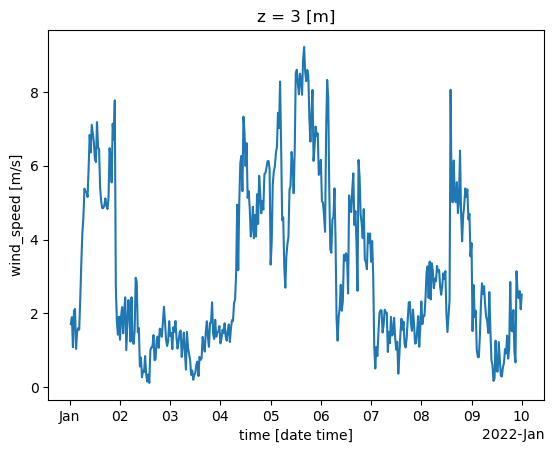

In [42]:

nc_output.wind_speed.sel(time=slice('2022-01-01T00:00:00.000000000','2022-01-10T00:00:00.000000000'),z=3).plot()